# What is the driving force of GNF? - 4

Local fluctuations might be related to energy, enstrophy and vorticity. 

## 1. Improve the speed of df2 code

In the old implementation, it took 30 s to calculate the variation over 50 frames, where only 9 boxes were taken into account. Imagine if we want to sample the whole image and get local variation everywhere, 50 frames will take several minutes. Here, we try to speed up the code by vectorization.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corrLib
from skimage import io
import os
from corr_utils import *
import time
from myImageLib import dirrec
from scipy.signal import savgol_filter
import typesetting.main as tm
tm.prl('1-column-2-panel')
import cv2
from miscLib import label_slope

### 1.1 Vectorized code

In [2]:
img_folder = r'E:\moreData\08032020\00\8-bit'

In [109]:
%%time
img_nums = range(901, 950)
l = corrLib.readseq(img_folder).loc[img_nums]
img_seq = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    img_seq.append(I) 
img_stack = np.stack([img_seq], axis=0)
img_stack = np.squeeze(img_stack)
std = np.std(img_stack, axis=0)

Wall time: 510 ms


### 1.2 Old code

In [107]:
%%time
img_nums = range(901, 950)
l = corrLib.readseq(img_folder).loc[img_nums]
df = pd.DataFrame()
for num, i in l.iterrows():
    img = io.imread(i.Dir)    
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    tempdf = pd.DataFrame().assign(I=I.flatten(), t=int(i.Name), number=range(0, len(I.flatten())))
    df = df.append(tempdf)
stdL = []
nL = []
for n in df.number.drop_duplicates():
    subdata = df.loc[df.number==n]
    std = subdata.I.std()
    stdL.append(std)
    nL.append(n)
std = np.array(stdL).reshape(42, 50)

Wall time: 2.65 s


### 1.3 Conclusion
New algorithm is faster by ~5 times than old algorithm. They give the same results.

## 2. Compute vorticity

In [112]:
piv_folder = r'E:\moreData\08032020\piv_imseq\00'
pivData = pd.read_csv(os.path.join(piv_folder, '0900-0901.csv'))
X = np.array(pivData.x).reshape(42, 50)
Y = np.array(pivData.y).reshape(42, 50)
U = np.array(pivData.u).reshape(42, 50)
V = np.array(pivData.v).reshape(42, 50)

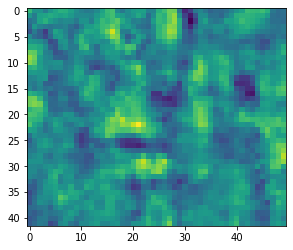

In [182]:
vort = vorticity(pivData)
plt.imshow(vort)

## 3. Compute local density fluctuation time series

### 3.1 local density fluctuations function

In [3]:
# local_df test code
img_folder = r'E:\moreData\08032020\00\8-bit'
l = corrLib.readseq(img_folder)
print('number of images: ' + str(len(l)) + ', time needed: {:.2f} s'.format(133.89/3600*len(l)))
tic = time.monotonic()
df = local_df(img_folder)
toc = time.monotonic()
print('time taken: {:.2f} s'.format(toc-tic))

number of images: 3600, time needed: 133.89 s
time taken: 36.27 s


### 3.2 Save the results

In [4]:
save_folder = r'E:\moreData\08032020\local_df\00'
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
for t, std in zip(df['t'], df['std']):
    np.save(os.path.join(save_folder, '{:04d}.npy'.format(t)), std)

### 3.3 Load the results

In [15]:
save_folder = r'E:\moreData\08032020\local_df\00'
l = dirrec(save_folder, '*.npy')
t = []
std = []
for i in l:
    f, n = os.path.split(i)
    name = n.split('.')[0]
    t.append(int(name))
    std.append(np.load(i))

## 4. Compute vorticity time series

### 4.1 Compute and save

In [13]:
piv_folder = r'E:\moreData\08032020\piv_imseq\11'
save_folder = r'E:\moreData\08032020\vorticity\11'
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
l = corrLib.readdata(piv_folder)
print('Number of data: ' + str(len(l)) + ', time needed: {:.2f} s'.format(len(l)/1800*47.20))
tic = time.monotonic()
for num, i in l.iterrows():
    pivData = pd.read_csv(i.Dir)
    vort = vorticity(pivData)
    np.save(os.path.join(save_folder, i.Name+'.npy'), vort)
toc = time.monotonic()
print('Time taken: {:.2f} s'.format(toc-tic))

Number of data: 1800, time needed: 47.20 s
Time taken: 39.52 s


### 4.2 Load the results

In [ ]:
vort = np.load(os.path.join(save_folder, '3500-3501.npy'))

## 5. Correlation between vorticity field and local density fluctuations

### 5.1 One-frame correlation

In [19]:
df_folder = r'E:\moreData\08032020\local_df\04'
vort_folder = r'E:\moreData\08032020\vorticity\04'

starting_frame = 2500
df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame, starting_frame+1)))

corr2d(df, vort**2)

0.0011637465326012196

### 5.2 Add more statistics: average over multiple frames

Averge correlation between vorticity square and local density fluctuations is 0.031


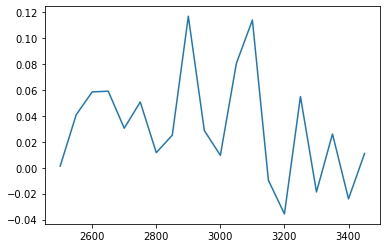

In [20]:
frame_list = range(2500, 3500, 50)
corrL = []
for starting_frame in frame_list:
    df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
    vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame, starting_frame+1)))
    corrL.append(corr2d(df, vort**2))
plt.plot(frame_list, corrL)
print('Averge correlation between vorticity square and local density fluctuations is {:.3f}'.format(np.array(corrL).mean()))

### 5.3 Scatter the correlations at each frame, instead of averaging them

The axis would be density fluctuations and enstrophy.

Text(0, 0.5, 'enstrophy [s$^{-2}$]')

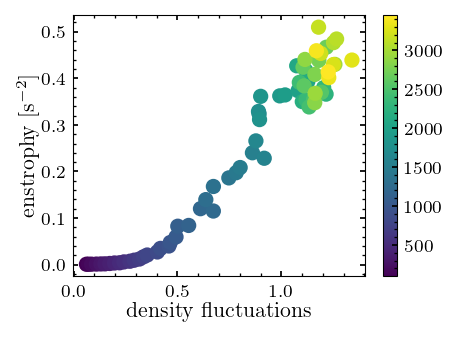

In [121]:
df_folder = r'E:\moreData\08032020\local_df\02'
vort_folder = r'E:\moreData\08032020\vorticity\02'
frame_list = range(100, 3500, 50)
dfL = []
vortL = []
for starting_frame in frame_list:
    df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
    vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame, starting_frame+1)))
    dfL.append(df.mean())
    vortL.append((vort**2).mean())
plt.figure(figsize=(3, 2.2))
plt.scatter(dfL, vortL, c=frame_list)
plt.colorbar()
plt.xlabel('density fluctuations')
plt.ylabel('enstrophy [s$^{-2}$]')

### 5.4 Local correlation in one frame

According to the temporal evolution data, after 2500 frame the system reaches a high density fluctuation and enstrophy and stopped increasing. Here I pick a frame in this regime and examine local df and enstrophy correlation.

Text(0, 0.5, 'enstrophy')

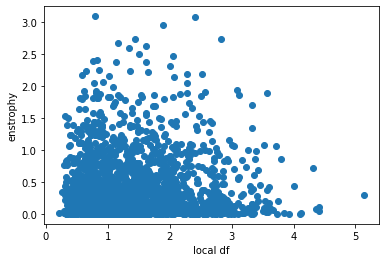

In [59]:
df_folder = r'E:\moreData\08032020\local_df\01'
vort_folder = r'E:\moreData\08032020\vorticity\01'

frame = 2500

df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(frame)))
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(frame, frame+1)))

plt.scatter(df, vort**2)
plt.xlabel('local df')
plt.ylabel('enstrophy')
# plt.axis([0, 2, 0, 2])

### 5.5 All the samples

In [22]:
master_folder = r'E:\moreData\08032020'
df_master_folder = os.path.join(master_folder, 'local_df')
vort_master_folder = os.path.join(master_folder, 'vorticity')
nL = range(0, 12)
corrL = []
for n in nL:
    df_folder =  os.path.join(df_master_folder, '{:02d}'.format(n))
    vort_folder = os.path.join(vort_master_folder, '{:02d}'.format(n))
    frame_list = range(2500, 3500, 50)
    dt = 0
    corr_list = []
    for starting_frame in frame_list:
        df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
        vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
        corr_list.append(corr2d(df, vort**2))
    corr = np.array(corr_list).mean()
    print('{0:-4d} {1:-4.3f}'.format(n, corr))
    corrL.append(corr)

   0 -0.015
   1 -0.009
   2 -0.007
   3 0.035
   4 0.031
   5 0.034
   6 -0.008
   7 0.030
   8 0.017
   9 -0.037
  10 -0.026
  11 -0.031


In [23]:
# save data
data = pd.DataFrame({'sample': nL, 'corr': corrL})
data.to_csv(r'E:\moreData\08032020\local_df\corr_vort.csv', index=False)

**Comments:** Global density fluctuations grow with enstrophy, the same trend as that identified for flow energy. Locally, low df and enstrophy dominate. High df is prohibited at high enstrophy.

## 6. Correlation between vorticity and local df at different time

It's possible that the effect of vorticity on density fluctuations, or the opposite effect, has a delay time, i.e. the vorticity field at time $t_1$ results in a density fluctuations pattern at $t_2$. In this section, I vary $\Delta t$ between vorticity field and density fluctuations field, see if there exists a $\Delta t$ with significantly higher correlation. 

### 6.1 One-frame different time correlation

In [55]:
df_folder = r'E:\moreData\08032020\local_df\01'
vort_folder = r'E:\moreData\08032020\vorticity\01'
dt = 20
starting_frame = 900

df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))

corr2d(df, vort**2)

0.03425146629825328

### 6.2 Add more statistics to a $\Delta t$ value

$\Delta t$ is 0, averge correlation is -0.014


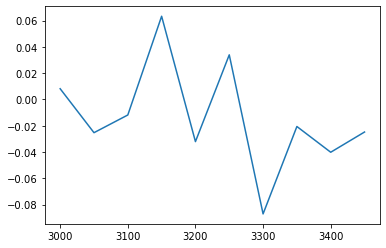

In [8]:
df_folder = r'E:\moreData\08032020\local_df\01'
vort_folder = r'E:\moreData\08032020\vorticity\01'
dt = -00

frame_list = range(3000, 3500, 50)
corrL = []
for starting_frame in frame_list:
    df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
    vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
    corrL.append(corr2d(df, vort**2))
plt.plot(frame_list, corrL)
print('$\Delta t$ is {0:d}, averge correlation is {1:.3f}'.format(dt, np.array(corrL).mean()))

### 6.3 Vary $\Delta t$ identify a highest correlation

Text(0, 0.5, 'correlation')

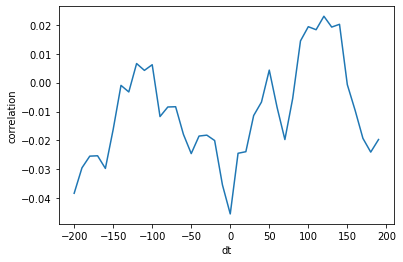

In [9]:
df_folder = r'E:\moreData\08032020\local_df\01'
vort_folder = r'E:\moreData\08032020\vorticity\01'
dtL = range(-200, 200, 10)
frame_list = range(2500, 3000, 50)

corrL = []
for dt in dtL:
    temp = []
    for starting_frame in frame_list:
        df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
        vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
        temp.append(corr2d(df, vort))
    corrL.append(np.array(temp).mean())
plt.plot(dtL, corrL)
plt.xlabel('dt')
plt.ylabel('correlation')

### 6.4 Local correlation

Text(0, 0.5, 'enstrophy')

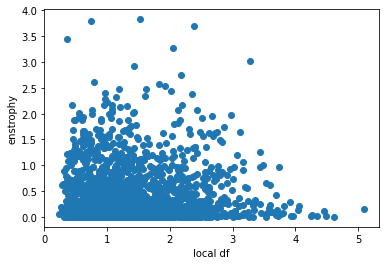

In [71]:
df_folder = r'E:\moreData\08032020\local_df\01'
vort_folder = r'E:\moreData\08032020\vorticity\01'

frame = 3000

dt = 26

df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(frame)))
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(frame+dt, frame+dt+1)))

plt.scatter(df, vort**2)
plt.xlabel('local df')
plt.ylabel('enstrophy')

## 7. Correlation between concentration and vorticity

### 7.1 One-frame test

In [181]:
img_folder = r'E:\moreData\08032020\01\8-bit'
vort_folder = r'E:\moreData\08032020\vorticity\01'
dt = 0
starting_frame = 3300

img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(starting_frame)))
X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))

corr2d(I, vort**2)

-0.005903518911753631

### 7.2 Vary $\Delta t$

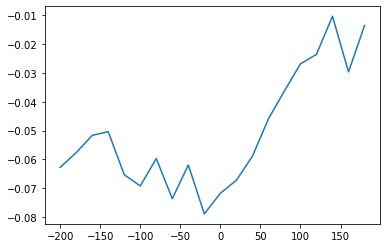

In [256]:
img_folder = r'E:\moreData\08032020\06\8-bit'
vort_folder = r'E:\moreData\08032020\vorticity\06'
dtL = range(-200, 200, 20)
frame_list = range(2500, 3200, 50)

corrL = []
for dt in dtL:
    temp = []
    for starting_frame in frame_list:
        img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(starting_frame)))
        X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
        vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
        temp.append(corr2d(I, vort**2))
    corrL.append(np.array(temp).mean())
plt.plot(dtL, corrL)

### 7.3 Local correlation between intensity and enstrophy in one frame

Text(0, 0.5, 'enstrophy')

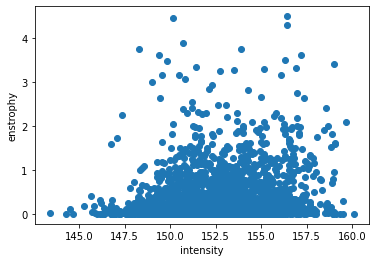

In [21]:
img_folder = r'E:\moreData\08032020\01\8-bit'
vort_folder = r'E:\moreData\08032020\vorticity\01'

frame = 3000

img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(frame)))
X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(frame, frame+1)))

plt.scatter(I, vort**2)
plt.xlabel('intensity')
plt.ylabel('enstrophy')

## 8. Local density fluctuations (LDF) and divergence of velocity (DIVV)

### 8.1 Calculate divergence of velocity (DIVV)

In [29]:
# test divergence function
%%time
pivData = pd.read_csv(r'E:\moreData\08032020\piv_imseq\01\3000-3001.csv')
div = divergence(pivData)

Wall time: 7 ms


(-0.5, 49.5, 41.5, -0.5)

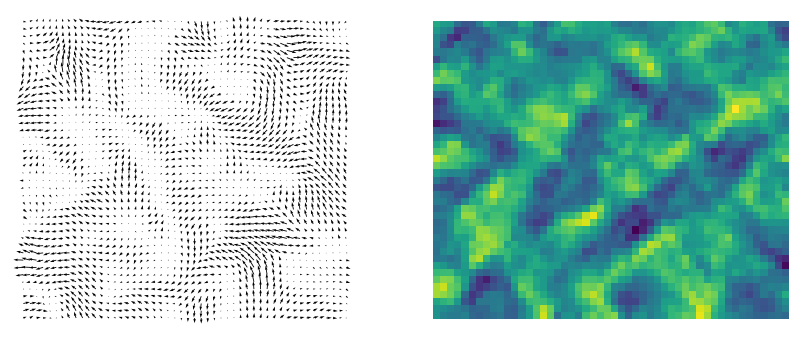

In [28]:
# verify the calculation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax[0].quiver(pivData.x, pivData.y, pivData.u, pivData.v)
ax[0].axis('off')
ax[1].imshow(div)
ax[1].axis('off')

### 8.2 Compute DIVV time series

In [31]:
master_folder = r'E:\moreData\08032020'
piv_master_folder = os.path.join(master_folder, 'piv_imseq')
divv_master_folder = os.path.join(master_folder, 'divv')
sfL = next(os.walk(piv_master_folder))[1]
for sf in sfL:
    n = int(sf)
    print('number ' + str(n))
    piv_folder =  os.path.join(piv_master_folder, '{:02d}'.format(n))
    save_folder = os.path.join(divv_master_folder, '{:02d}'.format(n))
    if os.path.exists(save_folder) == False:
        os.makedirs(save_folder)
    l = corrLib.readdata(piv_folder)
    print('Number of data: ' + str(len(l)) + ', time needed: {:.2f} s'.format(len(l)/1800*47))
    tic = time.monotonic()
    for num, i in l.iterrows():
        pivData = pd.read_csv(i.Dir)
        div = divergence(pivData)
        np.save(os.path.join(save_folder, i.Name+'.npy'), div)
    toc = time.monotonic()
    print('Time taken: {:.2f} s'.format(toc-tic))

number 0
Number of data: 1800, time needed: 47.00 s
Time taken: 28.61 s
number 1
Number of data: 1800, time needed: 47.00 s
Time taken: 40.95 s
number 2
Number of data: 1800, time needed: 47.00 s
Time taken: 44.33 s
number 3
Number of data: 1800, time needed: 47.00 s
Time taken: 48.44 s
number 4
Number of data: 1800, time needed: 47.00 s
Time taken: 45.72 s
number 5
Number of data: 1800, time needed: 47.00 s
Time taken: 48.53 s
number 6
Number of data: 1800, time needed: 47.00 s
Time taken: 51.84 s
number 7
Number of data: 1800, time needed: 47.00 s
Time taken: 47.17 s
number 8
Number of data: 1800, time needed: 47.00 s
Time taken: 43.33 s
number 9
Number of data: 1800, time needed: 47.00 s
Time taken: 33.12 s
number 10
Number of data: 1800, time needed: 47.00 s
Time taken: 32.25 s
number 11
Number of data: 1800, time needed: 47.00 s
Time taken: 32.94 s
number 12
Number of data: 50, time needed: 1.31 s
Time taken: 1.14 s
number 13
Number of data: 50, time needed: 1.31 s
Time taken: 1.0

### 8.3 One frame correlation

In [15]:
df_folder = r'E:\moreData\08032020\local_df\01'
divv_folder = r'E:\moreData\08032020\divv\01'
dt = 0
starting_frame = 2000

df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
div = np.load(os.path.join(divv_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))

corr2d(df, div**2)

-0.04849282769275271

### 8.4 Add more statistics

In [16]:
df_folder = r'E:\moreData\08032020\local_df\08'
divv_folder = r'E:\moreData\08032020\divv\08'
frame_list = range(2500, 3500, 50)
dt = 0
corr_list = []
for starting_frame in frame_list:
    df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
    div = np.load(os.path.join(divv_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
    corr_list.append(corr2d(df, div**2))
print(np.array(corr_list).mean())

0.003820919286760383


### 8.5 Different time correlation

Text(0, 0.5, 'correlation')

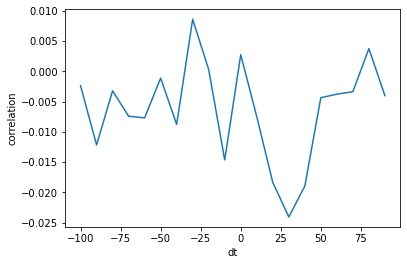

In [89]:
df_folder = r'E:\moreData\08032020\local_df\07'
divv_folder = r'E:\moreData\08032020\divv\07'
frame_list = range(2500, 3500, 50)
dtL = range(-100, 100, 10)
corr_list = []
for dt in dtL:
    temp = []
    for starting_frame in frame_list:
        df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
        div = np.load(os.path.join(divv_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
        temp.append(corr2d(df, div))
    corr_list.append(np.array(temp).mean())
plt.plot(dtL, corr_list)
plt.xlabel('dt')
plt.ylabel('correlation')

### 8.6 All the samples

In [20]:
master_folder = r'E:\moreData\08032020'
df_master_folder = os.path.join(master_folder, 'local_df')
div_master_folder = os.path.join(master_folder, 'divv')
nL = range(0, 12)
corrL = []
for n in nL:
    df_folder =  os.path.join(df_master_folder, '{:02d}'.format(n))
    div_folder = os.path.join(div_master_folder, '{:02d}'.format(n))
    frame_list = range(2500, 3500, 50)
    dt = 0
    corr_list = []
    for starting_frame in frame_list:
        df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
        div = np.load(os.path.join(div_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
        corr_list.append(corr2d(df, div**2))
    corr = np.array(corr_list).mean()
    print('{0:-4d} {1:-4.3f}'.format(n, corr))
    corrL.append(corr)

   0 -0.010
   1 -0.010
   2 -0.003
   3 0.026
   4 0.031
   5 0.037
   6 -0.011
   7 0.027
   8 0.004
   9 -0.034
  10 -0.013
  11 -0.028


In [21]:
# save data
data = pd.DataFrame({'sample': nL, 'corr': corrL})
data.to_csv(r'E:\moreData\08032020\local_df\corr_divv.csv', index=False)

### 8.7 Conclusion

No correlation between LDF and DIVV.

## 9. Convection (C) and local density fluctuations (LDF)

### 9.1 Compute convection term

In [98]:
%%time
# test convection function
pivData = pd.read_csv(r'E:\moreData\08032020\piv_imseq\01\3000-3001.csv')
image = io.imread(r'E:\moreData\08032020\01\8-bit\3000.tif')
winsize = 50
udc = convection(pivData, image, winsize)

Wall time: 17 ms


(-0.5, 49.5, 41.5, -0.5)

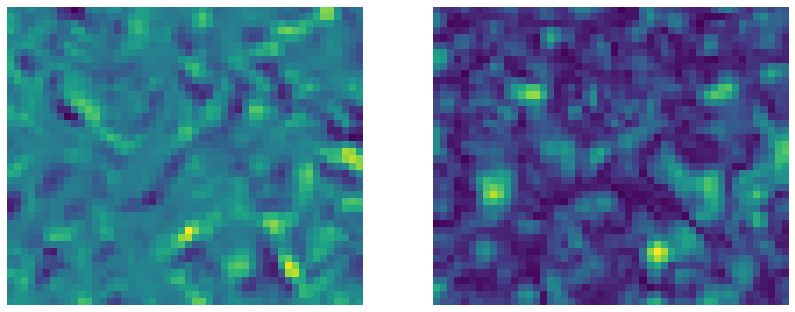

In [100]:
# verify the calculation
df = np.load(r'E:\moreData\08032020\local_df\01\3000.npy')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax[0].imshow(udc)
ax[0].axis('off')
ax[1].imshow(df)
ax[1].axis('off')

### 9.2 Compute convection time series

In [8]:
master_folder = r'E:\moreData\08032020'
piv_master_folder = os.path.join(master_folder, 'piv_imseq')
conv_master_folder = os.path.join(master_folder, 'convection')
sfL = next(os.walk(piv_master_folder))[1]
for sf in sfL:
    if sf != '00':
        break
    n = int(sf)
    print('number ' + str(n))
    piv_folder =  os.path.join(piv_master_folder, '{:02d}'.format(n))
    save_folder = os.path.join(conv_master_folder, '{:02d}'.format(n))
    if os.path.exists(save_folder) == False:
        os.makedirs(save_folder)
    img_folder = os.path.join(master_folder, '{:02d}'.format(n), '8-bit')
    
    l = corrLib.readdata(piv_folder)
    print('Number of data: ' + str(len(l)) + ', time needed: {:.2f} s'.format(len(l)/1800*110))
    tic = time.monotonic()
    for num, i in l.iterrows():
        pivData = pd.read_csv(i.Dir)
        
        # determine the image to use
        img_num = int(i.Name.split('-')[0])
        image = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(img_num)))
        conv = convection(pivData, image, 50)
        np.save(os.path.join(save_folder, i.Name+'.npy'), conv)
    toc = time.monotonic()
    print('Time taken: {:.2f} s'.format(toc-tic))

number 0
Number of data: 1800, time needed: 110.00 s
Time taken: 59.55 s


### 9.3 One frame correlation

In [16]:
master_folder = r'E:\moreData\08032020'
n = 1
df_master_folder = os.path.join(master_folder, 'local_df')
conv_master_folder = os.path.join(master_folder, 'convection')
df_folder =  os.path.join(df_master_folder, '{:02d}'.format(n))
conv_folder = os.path.join(conv_master_folder, '{:02d}'.format(n))

starting_frame = 2000
conv = np.load(os.path.join(conv_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame, starting_frame+1)))
df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))

corr2d(conv**2, df)

0.019367283399415194

### 9.4 Add more statistics

In [15]:
master_folder = r'E:\moreData\08032020'
n = 6
df_master_folder = os.path.join(master_folder, 'local_df')
conv_master_folder = os.path.join(master_folder, 'convection')
df_folder =  os.path.join(df_master_folder, '{:02d}'.format(n))
conv_folder = os.path.join(conv_master_folder, '{:02d}'.format(n))

frame_list = range(2500, 3500, 50)
dt = 0
corr_list = []
for starting_frame in frame_list:
    df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
    conv = np.load(os.path.join(conv_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
    corr_list.append(corr2d(df, conv**2))
print(np.array(corr_list).mean())

0.08749829957418237


### 9.5 All the samples

In [18]:
master_folder = r'E:\moreData\08032020'
df_master_folder = os.path.join(master_folder, 'local_df')
conv_master_folder = os.path.join(master_folder, 'convection')
nL = range(0, 12)
corrL = []
for n in nL:
    df_folder =  os.path.join(df_master_folder, '{:02d}'.format(n))
    conv_folder = os.path.join(conv_master_folder, '{:02d}'.format(n))
    frame_list = range(2500, 3500, 50)
    dt = 0
    corr_list = []
    for starting_frame in frame_list:
        df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
        conv = np.load(os.path.join(conv_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
        corr_list.append(corr2d(df, conv**2))
    corr = np.array(corr_list).mean()
    print('{0:-4d} {1:-4.3f}'.format(n, corr))
    corrL.append(corr)

   0 0.035
   1 0.042
   2 0.013
   3 0.068
   4 0.080
   5 0.093
   6 0.087
   7 0.059
   8 0.048
   9 -0.032
  10 -0.007
  11 -0.008


In [19]:
# save data
data = pd.DataFrame({'sample': nL, 'corr': corrL})
data.to_csv(r'E:\moreData\08032020\local_df\corr_convection.csv', index=False)

**<font color='green'>Comments:</font>** I found the highest correlation between the convection term $(u\cdot\nabla c)^2$ and the local density fluctuations $\Delta c$.

## 10. Compare the correlations

We have investigated the correlations between LDF and 3 other velocity related terms - vorticity sqaured, divergence squared and convectoin term squared. The reason I take the square of the velocity related terms is that LDF only measures the magnitude and ignores direction. 

### 10.1 Sample number as horizontal axis

Text(0, 0.5, 'correlation')

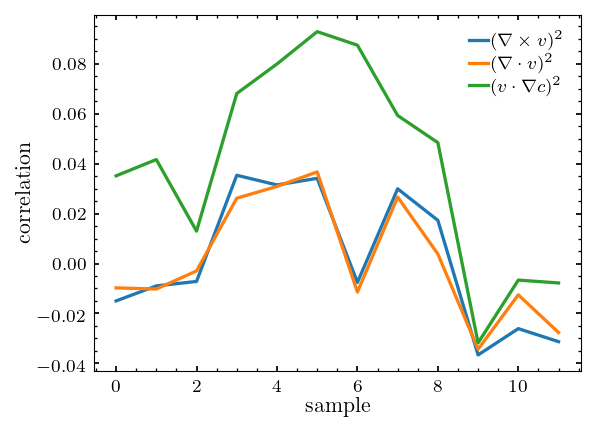

In [34]:
master_folder = r'E:\moreData\08032020\local_df'
corr1 = pd.read_csv(os.path.join(master_folder, 'corr_vort.csv'))
corr2 = pd.read_csv(os.path.join(master_folder, 'corr_divv.csv'))
corr3 = pd.read_csv(os.path.join(master_folder, 'corr_convection.csv'))
plt.figure(figsize=(4, 3))
plt.plot(corr1['sample'], corr1['corr'], label=r'$(\nabla\times v)^2$')
plt.plot(corr2['sample'], corr2['corr'], label=r'$(\nabla\cdot v)^2$')
plt.plot(corr3['sample'], corr3['corr'], label=r'$(v\cdot\nabla c)^2$')

plt.legend()
plt.xlabel('sample')
plt.ylabel('correlation')

### 10.2 Combine data with same concentration

In [39]:
corr = {}
master_folder = r'E:\moreData\08032020\local_df'
corr['1'] = pd.read_csv(os.path.join(master_folder, 'corr_vort.csv'))
corr['2'] = pd.read_csv(os.path.join(master_folder, 'corr_divv.csv'))
corr['3'] = pd.read_csv(os.path.join(master_folder, 'corr_convection.csv'))

In [46]:
corr_c = {}
conc = [80, 60, 40, 20]
sample_num = [range(0, 3), range(3, 6), range(6, 9), range(9, 12)]
for kw in corr:
    avg_list = []
    err_list = []
    for s in sample_num:
        avg_list.append(corr[kw].loc[s]['corr'].mean())
        err_list.append(corr[kw].loc[s]['corr'].std())
    corr_c[kw] = pd.DataFrame({'conc': conc, 'corr': avg_list, 'err': err_list})
    

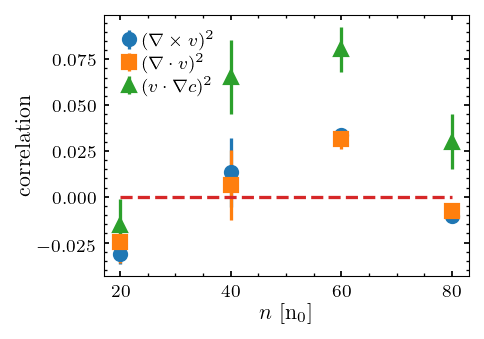

In [125]:
labels = {}
labels['1'] = r'$(\nabla\times v)^2$'
labels['2'] = r'$(\nabla\cdot v)^2$'
labels['3'] = r'$(v\cdot\nabla c)^2$'
markers = {'1': 'o', '2': 's', '3': '^'}
plt.figure(figsize=(3, 2.2))
for kw in corr_c:
    plt.errorbar(corr_c[kw]['conc'], corr_c[kw]['corr'], yerr=corr_c[kw]['err'], label=labels[kw],
                ls='', marker=markers[kw])
    
plt.legend(loc='upper left')
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('correlation')
plt.plot([20, 80], [0, 0], ls='--')

## 11. Conclusion

I found the highest correlation between the convection term $(u\cdot\nabla c)^2$ and the local density fluctuations $\Delta c$.

## 12. Make some pictures for presentation

(-0.5, 105.025, 105.025, -0.5)

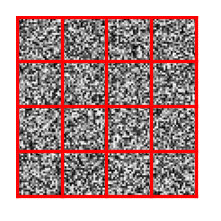

In [108]:
plt.figure(figsize=(2, 1.6))
uni = np.random.randint(136, 168, (100, 100))
plt.imshow(uni, cmap='gray')
X, Y = np.meshgrid(np.linspace(0, 100, 5), np.linspace(0, 100, 5))
plt.plot(X, Y, color='red')
plt.plot(Y, X, color='red')
# plt.colorbar()
plt.axis('off')

(-0.5, 105.025, 105.025, -0.5)

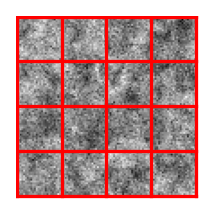

In [109]:
plt.figure(figsize=(2, 1.6))
img = io.imread(r'E:\moreData\08032020\01\8-bit\3000.tif')
img_sc = cv2.resize(img, (100, 100))
plt.imshow(img_sc, cmap='gray')
X, Y = np.meshgrid(np.linspace(0, 100, 5), np.linspace(0, 100, 5))
plt.plot(X, Y, color='red')
plt.plot(Y, X, color='red')
# plt.colorbar()
plt.axis('off')

(-0.5, 3.5, 3.5, -0.5)

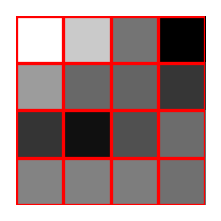

In [124]:
plt.figure(figsize=(2, 1.6))
img = io.imread(r'E:\moreData\08032020\01\8-bit\3000.tif')
img_sc = cv2.resize(img, (100, 100))
X, Y, I = corrLib.divide_windows(img_sc, windowsize=[25, 25], step=25)
plt.imshow(I, cmap='gray')
X, Y = np.meshgrid(np.linspace(0, 4, 5), np.linspace(0, 4, 5))
plt.plot(X-0.5, Y-0.5, color='red')
plt.plot(Y-0.5, X-0.5, color='red')
# plt.colorbar()
plt.axis('off')

(2.5, 30.0, 0.9, 2.0)

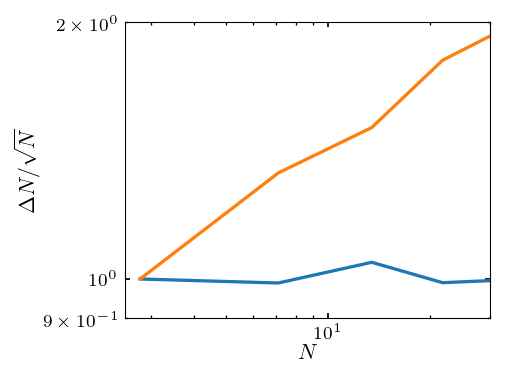

In [120]:
plt.figure(figsize=(3, 2.5))
data = corrLib.density_fluctuation(uni)
x, y = postprocess_gnf(data, 3)
plt.plot(x, y)
data = corrLib.density_fluctuation(img_sc)
x, y = postprocess_gnf(data, 3)
plt.plot(x, y)
plt.xlabel('$N$')
plt.ylabel('$\Delta N/\sqrt{N}$')
plt.loglog()
plt.axis([2.5, 30, 0.9, 2])

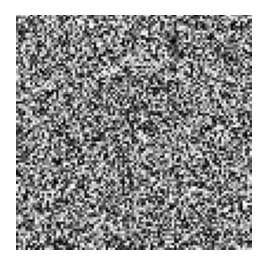

In [9]:
fig = plt.figure(figsize=(1.5, 1.5))
ax = fig.add_axes([0, 0, 1, 1])
for i in range(0, 20):
    rand = np.random.randint(0, 255, (100, 100))
    np.save(r'E:\Google Drive\Research projects\DF\pictures&videos\random_noise\raw\{:02d}.npy'.format(i), rand)
    ax.imshow(rand, cmap='gray')
    ax.axis('off')
    fig.savefig(r'E:\Google Drive\Research projects\DF\pictures&videos\random_noise\pics\{:02d}.jpg'.format(i))

In [35]:
folder = r'E:\Google Drive\Research projects\DF\pictures&videos\random_noise\raw'
l = dirrec(folder, '*.npy')
N = []
dN = []
for bs in range(5, 30):
    roi_list = []
    for d in l:
        img = np.load(d)
        roi = img[50-bs:50+bs, 50-bs:50+bs]
        roi_list.append(roi.sum())
    N.append(np.array(roi_list).mean())
    dN.append(np.array(roi_list).std())
N = np.array(N)
dN = np.array(dN)

Text(0, 0.5, '$\\Delta N$')

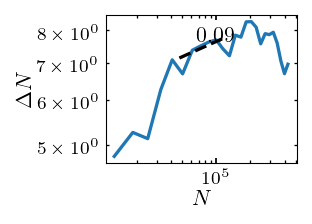

In [38]:
plt.plot(N, dN/N**0.5)
plt.loglog()
xf, yf, xt, yt, slope = label_slope(N, dN/N**0.5, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.loglog()
plt.xlabel('$N$')
plt.ylabel('$\Delta N$')

In [29]:
bs

45